In [100]:
import pandas as pd
import geopandas as gpd

In [101]:
# Get satisfaction data
df_satis = pd.read_pickle("pickles/utseus-cendus-satisfaction.pk")
df_satis.head()

,StreetID,Street,LifeSatisfaction1,Satisfaction2
0,310101002000,ÄÏ¾©¶«Â·½ÖµÀ,78.970207,77.512672
1,310101013000,ÍâÌ²½ÖµÀ,75.061508,72.304123
2,310101018000,Ô¥Ô°½ÖµÀ,78.704926,75.498878
3,310101020000,ÎåÀïÇÅ½ÖµÀ,81.028603,80.842705
4,310101021000,´òÆÖÇÅ½ÖµÀ,79.084648,79.284386


In [102]:
from bs4 import BeautifulSoup
import requests as rq
import json
import hashlib
import time
import random
import re
import urllib

In [66]:
# IDEA 1 -> BAIDU API CALL : convert the address into coordinates
# Didn't work - abandoned
def callBaiduGeocoderAPI(address):
    params = {
        'city':'上海市',
        'address':address,
        'output':'json',
        'ak':"CNl8w1Yf21CIWj8AFqauV4Lrh9GIiLst"
    }
    
    # http://api.map.baidu.com/geocoding/v3/?address=北京市海淀区上地十街10号&output=json&ak=您的ak&callback=showLocation
    queryStr = '/geocoding/v3/?' + '&'.join([k+'='+v for k,v in params.items()])
    
    encodedStr = urllib.parse.quote(queryStr, safe="/:=&?#+!$,;'@()*[]")
    rawStr = encodedStr + 'NHx7GLQ1ERanwxdciofQfIqZ9r2tWUV5' # add the sk
    sn = (hashlib.md5(urllib.parse.quote_plus(rawStr).encode("utf8")).hexdigest())
    query = 'http://api.map.baidu.com' + queryStr + '&sn=' + sn

    result = rq.get(query)
    resultJson = result.json()
    
    try:
        lat = resultJson['result']['location']['lat']
        lon = resultJson['result']['location']['lng']
    except Exception:
        if 'msg' in resultJson:
            print(resultJson['msg'])
        else:
            print('reached api limit', resultJson['message'])
            exit()
        return None, None
    #latitude, longitude = gcj02_decrypt(lat, lon)
    return latitude, longitude

In [ ]:
# IDEA 2 -> Chinese to Pinyin -> Pinyin to Address -> Address to Location
# Problem: Coordinates not accurate
# Abandoned
# delim = ['jiedao','qu','zhen','lu']
def chinese_to_pinyin(word):
    word = pinyin.get(word, format="strip")
    if word[-6:] == "jiedao":
        word = word.replace("jiedao", " jiedao")
    if word[-2:] == "qu":
        word = word.replace("qu", " qu")
    if word[-2:] == "lu":
        word = word.replace("lu", " lu")
    if word[-2:] == "zhen":
        word = word.replace("zhen", " zhen")
    address = word
    return address

for i, row in df_satis.iterrows():
    url = "https://www.xzqy.net/" + row['StreetID'].rstrip() + ".htm"
    
    headers = {
        'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.79 Safari/537.36",
        'Accept': "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
        'Sec-Fetch-Site': "none",
        'Sec-Fetch-Mode': "navigate",
        'Referer': "https://cn.bing.com/",
        'Accept-Encoding': "gzip, deflate, br",
        'Accept-Language': "cn-CN,cn;q=0.9,en-US;q=0.8,en;q=0.7",
        'Content-Type': 'charset=UTF-8',
        'ensure_ascii': 'True'
    }

    resp = rq.request("GET", url, headers=headers)

    # Error handler
    if(resp.status_code != 200) :
        print("STATUS_CODE ERROR", resp.status_code, resp.text)

    # Response handler
    data = resp.text

    html = BeautifulSoup(data, 'html5lib')

    test = html.find_all('h1')[0].contents[0]
    
    df_satis.set_value(i, 'ChineseName', test)

In [ ]:
import pinyin
df_satis['PinyinName'] = df_satis['ChineseName'].apply(lambda x: pinyin.get(x, format="strip", delimiter=" "))
df_satis.head()

In [ ]:
for i, area in df_satis.iterrows():
    place = area['PinyinName'].title() + " Shanghai"
    url = "https://geocode.xyz"

    payload = "locate=" + place + "&geoit=JSON"
    headers = {
        'User-Agent': "PostmanRuntime/7.20.1",
        'Accept': "*/*",
        'Cache-Control': "no-cache",
        'Postman-Token': "5a9759d4-83eb-4fbc-8735-fc560007399d,c170d1a8-8b40-46f2-9cc8-fcaec1707e13",
        'Host': "geocode.xyz",
        'Content-Type': "application/x-www-form-urlencoded",
        'Accept-Encoding': "gzip, deflate",
        'Content-Length': "40",
        'Cookie': "__cfduid=d5c9adcb478db8c0b35f8729393383c9a1576186322; xyzh=xyzh",
        'Connection': "keep-alive",
        'cache-control': "no-cache"
        }

    response = rq.request("POST", url, data=payload, headers=headers)

    print(response.text)
    
    break

In [103]:
# Shanghai map
df_neigh = pd.read_pickle("pickles/utseus-cendus-shanghai-neighborhoods.pk")
df_neigh.head()

,NAME,TYPE,geometry
0,??,2,"POLYGON Z ((121.42168 30.68471 0.00000, 121.42..."
1,???,2,"POLYGON Z ((121.41199 30.69374 0.00000, 121.41..."
2,???,2,"POLYGON Z ((121.40163 30.70717 0.00000, 121.40..."
3,????,2,"POLYGON Z ((121.33687 30.73806 0.00000, 121.33..."
4,????,2,"POLYGON Z ((121.25143 30.79177 0.00000, 121.25..."


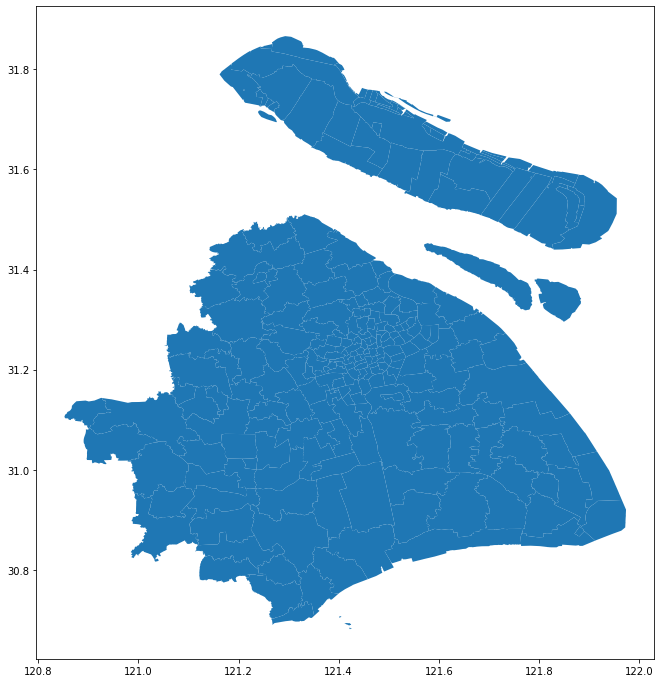

In [105]:
# Print Shanghai neighborhood
gdf_sh = gpd.GeoDataFrame(df_neigh, geometry=df_neigh.geometry)
gdf_sh.plot(figsize=(18,12))

In [107]:
# Get dianping data 
# Goal : Get all sports poi of Shanghai
df_dianping = pd.read_pickle("pickles/utseus-poi-dianping.pk")
df_dianping.head()

,name,branch_name,address,telephone,city,latitude,longitude,avg_rating,product_grade,decoration_grade,service_grade,product_score,decoration_score,service_score,review_count,avg_price,photo_count,category
business_id,,,,,,,,,,,,,,,,,,
500000,阿凡提美食娱乐城(这是一条测试商户数据，仅用于测试开发，开发完成后请申请正式数据...),,虹口区曲阳路775号天山宾馆B1楼,021-65559604,上海,31.288305,121.490440,30.0,1.0,1.0,1.0,6.8,6.3,6.3,482,81.0,140.0,新疆菜
500001,萨莎(这是一条测试商户数据，仅用于测试开发，开发完成后请申请正式数据...),,徐汇区东平路11号,021-64746628,上海,31.208550,121.449710,40.0,1.0,1.0,1.0,7.3,8.4,7.4,891,149.0,441.0,酒吧
500001,萨莎(这是一条测试商户数据，仅用于测试开发，开发完成后请申请正式数据...),,徐汇区东平路11号,021-64746628,上海,31.208550,121.449710,40.0,1.0,1.0,1.0,7.3,8.4,7.4,891,149.0,441.0,牛排
500003,1221餐馆(这是一条测试商户数据，仅用于测试开发，开发完成后请申请正式数据...),,长宁区延安西路1221号,021-62136585,上海,31.211315,121.427780,35.0,1.0,1.0,1.0,7.1,7.4,7.6,369,144.0,182.0,本帮菜
500008,Food Live(这是一条测试商户数据，仅用于测试开发，开发完成后请申请正式数据...),,浦东新区世纪大道88号金茂君悦大酒店B1楼,021-50491234-8283,上海,31.235252,121.505745,30.0,1.0,1.0,1.0,6.1,6.3,6.3,38,26.0,12.0,快餐简餐


In [108]:
# Find the interesting categories
categories = ['保龄球馆','高尔夫场','瑜伽','健身中心','游泳馆','瘦身纤体','运动户外','舞蹈','篮球场','足球场','乒乓球馆','空手道馆','攀岩馆','网球场','体育场馆','游乐场','羽毛球馆','射箭馆','武术','溜冰场','桌球馆','壁球馆','跆拳道馆','真人CS','马术场','运动场馆']

In [109]:
# Filter the data with categories
df_dianping_sport = df_dianping[df_dianping.category.isin(categories)]

In [110]:
df_dianping_sport

,name,branch_name,address,telephone,city,latitude,longitude,avg_rating,product_grade,decoration_grade,service_grade,product_score,decoration_score,service_score,review_count,avg_price,photo_count,category
business_id,,,,,,,,,,,,,,,,,,
1794997,东联保龄球(这是一条测试商户数据，仅用于测试开发，开发完成后请申请正式数据...),,虹口区源林路150号,,上海,31.276915,121.485410,35.0,0.0,0.0,0.0,0.0,0.0,0.0,11,0.0,1.0,保龄球馆
1795006,富豪环球东亚酒店保龄球馆(这是一条测试商户数据，仅用于测试开发，开发完成后请申请正式数据...),,徐汇区衡山路516号,021-64155588,上海,31.201677,121.443830,40.0,0.0,0.0,0.0,0.0,0.0,0.0,35,79.0,8.0,保龄球馆
1795009,高点保龄球 桌球(这是一条测试商户数据，仅用于测试开发，开发完成后请申请正式数据...),虹口店,虹口区东江湾路456号,021-56711111,上海,31.272305,121.479675,40.0,0.0,0.0,0.0,0.0,0.0,0.0,2495,55.0,516.0,保龄球馆
1795042,金皇子保龄球馆(这是一条测试商户数据，仅用于测试开发，开发完成后请申请正式数据...),,宝山区牡丹江路1769号,021-56609446,上海,31.406572,121.481450,30.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,4.0,保龄球馆
1795045,锦辉宾馆保龄球馆(这是一条测试商户数据，仅用于测试开发，开发完成后请申请正式数据...),,长宁区吴中路8号,,上海,31.189201,121.419655,30.0,0.0,0.0,0.0,0.0,0.0,0.0,8,0.0,4.0,保龄球馆
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19402487,明翼舞蹈会所(这是一条测试商户数据，仅用于测试开发，开发完成后请申请正式数据...),翔殷路店,杨浦区安波路569号硕和国际1号楼909(近营口路),4000550005-116,上海,31.301390,121.527626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,16.0,舞蹈
19407590,梅陇镇老年人羽毛球俱乐部(这是一条测试商户数据，仅用于测试开发，开发完成后请申请正式数据...),,闵行区高兴路108号,,上海,31.100750,121.400460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,羽毛球馆
19409299,的NDUJS(这是一条测试商户数据，仅用于测试开发，开发完成后请申请正式数据...),,徐汇区的把控,,上海,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,空手道馆


In [111]:
# Clean the data -> longitude & Latitude = 0
df_dianping_sport_cleaned = df_dianping_sport[(df_dianping_sport['longitude'] > 1) & (df_dianping_sport['latitude'] > 1)]

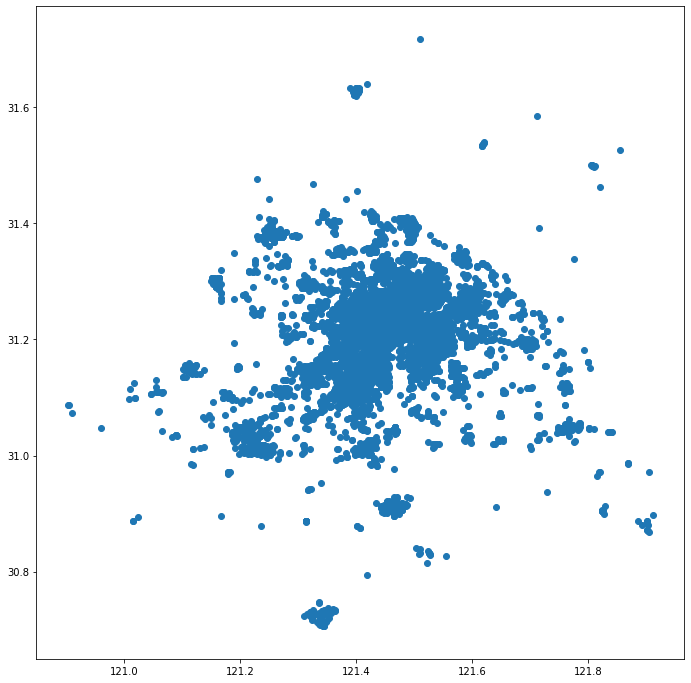

In [112]:
# Print data points of Dianping
from shapely.geometry import Point
gdf_dianping = gpd.GeoDataFrame(df_dianping_sport_cleaned, geometry=gpd.points_from_xy(df_dianping_sport_cleaned['longitude'],df_dianping_sport_cleaned['latitude']))
gdf_dianping.plot(figsize=(18,12))

In [113]:
gdf_dianping.to_csv("dianping.csv")

In [114]:
gdf_dianping.head()

,name,branch_name,address,telephone,city,latitude,longitude,avg_rating,product_grade,decoration_grade,service_grade,product_score,decoration_score,service_score,review_count,avg_price,photo_count,category,geometry
business_id,,,,,,,,,,,,,,,,,,,
1794997,东联保龄球(这是一条测试商户数据，仅用于测试开发，开发完成后请申请正式数据...),,虹口区源林路150号,,上海,31.276915,121.485410,35.0,0.0,0.0,0.0,0.0,0.0,0.0,11,0.0,1.0,保龄球馆,POINT (121.48541 31.27691)
1795006,富豪环球东亚酒店保龄球馆(这是一条测试商户数据，仅用于测试开发，开发完成后请申请正式数据...),,徐汇区衡山路516号,021-64155588,上海,31.201677,121.443830,40.0,0.0,0.0,0.0,0.0,0.0,0.0,35,79.0,8.0,保龄球馆,POINT (121.44383 31.20168)
1795009,高点保龄球 桌球(这是一条测试商户数据，仅用于测试开发，开发完成后请申请正式数据...),虹口店,虹口区东江湾路456号,021-56711111,上海,31.272305,121.479675,40.0,0.0,0.0,0.0,0.0,0.0,0.0,2495,55.0,516.0,保龄球馆,POINT (121.47968 31.27230)
1795042,金皇子保龄球馆(这是一条测试商户数据，仅用于测试开发，开发完成后请申请正式数据...),,宝山区牡丹江路1769号,021-56609446,上海,31.406572,121.481450,30.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,4.0,保龄球馆,POINT (121.48145 31.40657)
1795045,锦辉宾馆保龄球馆(这是一条测试商户数据，仅用于测试开发，开发完成后请申请正式数据...),,长宁区吴中路8号,,上海,31.189201,121.419655,30.0,0.0,0.0,0.0,0.0,0.0,0.0,8,0.0,4.0,保龄球馆,POINT (121.41966 31.18920)


In [115]:
gdf_sh.to_csv("shanghai.csv")

In [116]:
gdf_sh.head()

,NAME,TYPE,geometry
0,??,2,"POLYGON Z ((121.42168 30.68471 0.00000, 121.42..."
1,???,2,"POLYGON Z ((121.41199 30.69374 0.00000, 121.41..."
2,???,2,"POLYGON Z ((121.40163 30.70717 0.00000, 121.40..."
3,????,2,"POLYGON Z ((121.33687 30.73806 0.00000, 121.33..."
4,????,2,"POLYGON Z ((121.25143 30.79177 0.00000, 121.25..."


In [117]:
gdf_sh['nb_poi'] = 0

In [119]:
# Get the number of POI in each neighborhood
for i, poi in gdf_dianping.iterrows():
    for j, area in gdf_sh.iterrows():
        if(poi['geometry'].within(area['geometry'])):
            gdf_sh.set_value(j, 'nb_poi', gdf_sh.iloc[j]['nb_poi']+1)

D:\Programmes\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


In [120]:
gdf_sh.head()

,NAME,TYPE,geometry,nb_poi
0,??,2,"POLYGON Z ((121.42168 30.68471 0.00000, 121.42...",0
1,???,2,"POLYGON Z ((121.41199 30.69374 0.00000, 121.41...",0
2,???,2,"POLYGON Z ((121.40163 30.70717 0.00000, 121.40...",0
3,????,2,"POLYGON Z ((121.33687 30.73806 0.00000, 121.33...",57
4,????,2,"POLYGON Z ((121.25143 30.79177 0.00000, 121.25...",2


In [121]:
gdf_sh.to_csv("best_shanghai.csv")